# 0. Imports

In [1]:
import netCDF4 as nc 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm, BoundaryNorm, ListedColormap
import os
from PIL import Image

# 1. Getting the Dataset

In [2]:
# defining the path to file  
filePath = '15july2012.nc'  
  
# using the Dataset() function  
dSet = nc.Dataset(filePath) 
dSet

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    history: PyFerret V7.65 (optimized) 31-Oct-23
    Conventions: CF-1.6
    CDI: Climate Data Interface version 2.1.0 (https://mpimet.mpg.de/cdi)
    source: RSS AMSR2 V8.2 AS-ECV Algorithms
    institution: Remote Sensing Systems, Santa Rosa, CA, USA
    summary: RSS climate quality air-sea products (SST, wind, vapor, cloud, rain), derived from JAXA microwave radiometer AMSR2 aboard JAXA GCOM-W1, produced by Remote Sensing Systems, gridded at .25 degree resolution in time averaged files, carefully intercallibrated with other microwave radiometers and scatterometers including WindSat, GMI, and ASCAT.
    version: 8.2
    processing_level: Level 3: monthly maps
    date_created: 2021-05-12T05:17:36Z
    sensor: AMSR2
    platform: GCOM-W1
    instrument: AMSR2 radiometer
    project: Air-Sea Essential Climate Variables (AS-ECV) from Satellite Microwave Radiometers
    keywords: sea surface

In [3]:
dSet.dimensions

{'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 1440,
 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 720,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1}

In [4]:
dSet.variables

{'lon': <class 'netCDF4._netCDF4.Variable'>
 float32 lon(lon)
     long_name: center longitude of grid cell
     units: degrees_east
     axis: X
     modulo: 360.0
     point_spacing: even
     standard_name: longitude
 unlimited dimensions: 
 current shape = (1440,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float32 lat(lat)
     long_name: center latitude of grid cell
     units: degrees_north
     axis: Y
     point_spacing: even
     standard_name: latitude
 unlimited dimensions: 
 current shape = (720,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     units: months since 2012-07-15 12:00
     calendar: proleptic_gregorian
     axis: T
     standard_name: time
 unlimited dimensions: time
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'wind_speed_AW': <class 'netCDF4._netCDF4.Variable'>
 float32 w

In [5]:
# the null values counts
unique, counts = np.unique(dSet['wind_speed_AW'][:].mask, return_counts=True)
# print(np.asarray((unique, counts)))
print(f"there are {counts[0]} null values out of {counts[0] + counts[1]} which is about {counts[0]/(counts[0]+counts[1])*100}%")

there are 518378 null values out of 1036800 which is about 49.99787808641975%


In [6]:
print(np.asarray((unique, counts)))

[[     0      1]
 [518378 518422]]


In [7]:
longitude = dSet["lon"][:].data

In [8]:
latitude = dSet["lat"][:].data

In [9]:
wind_speed_data = dSet['wind_speed_AW'][:].data.squeeze()
wind_speed_data[wind_speed_data < 0] = np.nan
wind_speed_data.shape

(720, 1440)

# 2. Important Observations about the Data

In [10]:
# getting all the file names and dates
dates = [1, 8, 15, 22, 29]
months = ["aug", "sept", "oct"]
complete_dates = []
file_paths = []
for month in months:
    for date in dates:
        temp = "./dataset/"+str(date)+month+"2022.nc"
        file_paths.append(temp)
        temp = str(date)+month+"2022"
        complete_dates.append(temp)
        
file_paths, complete_dates

(['./dataset/1aug2022.nc',
  './dataset/8aug2022.nc',
  './dataset/15aug2022.nc',
  './dataset/22aug2022.nc',
  './dataset/29aug2022.nc',
  './dataset/1sept2022.nc',
  './dataset/8sept2022.nc',
  './dataset/15sept2022.nc',
  './dataset/22sept2022.nc',
  './dataset/29sept2022.nc',
  './dataset/1oct2022.nc',
  './dataset/8oct2022.nc',
  './dataset/15oct2022.nc',
  './dataset/22oct2022.nc',
  './dataset/29oct2022.nc'],
 ['1aug2022',
  '8aug2022',
  '15aug2022',
  '22aug2022',
  '29aug2022',
  '1sept2022',
  '8sept2022',
  '15sept2022',
  '22sept2022',
  '29sept2022',
  '1oct2022',
  '8oct2022',
  '15oct2022',
  '22oct2022',
  '29oct2022'])

In [11]:
# distribution = np.array([10, 20.0])
num = 20
total = 0
count = 0
maxx = 0
for file_path in file_paths:
    dSet = nc.Dataset(file_path)
    wind_speed_data = dSet['wind_speed_AW'][:].data.squeeze()
    print(np.max(wind_speed_data))
    maxx = max(maxx, np.max(wind_speed_data).item())
    wind_speed_data[wind_speed_data < 0] = np.nan
    temp = wind_speed_data[wind_speed_data>num].reshape(-1).shape[0]
    count+=temp
    total += wind_speed_data.reshape(-1).shape[0] 

print(f"the percentage of values > {num} is {count/total * 100}%")
print(f"the maximum value turned out to be {maxx}")

31.492453
46.552002
39.019833
43.327
28.754572
28.744
35.064
60.535336
27.753502
29.120998
35.314
32.662003
32.211945
28.358177
37.9715
the percentage of values > 20 is 0.01194701646090535%
the maximum value turned out to be 60.535335540771484


### NOTE:
from the above piece of code it is clear that our values are not greater than 20 for most of the times but the maximum value found was about 60 which will lead to the values in range(0-20) not being distinguished to their fullest.

# 3. ColorMaps

## 3.1 Linear Colormap

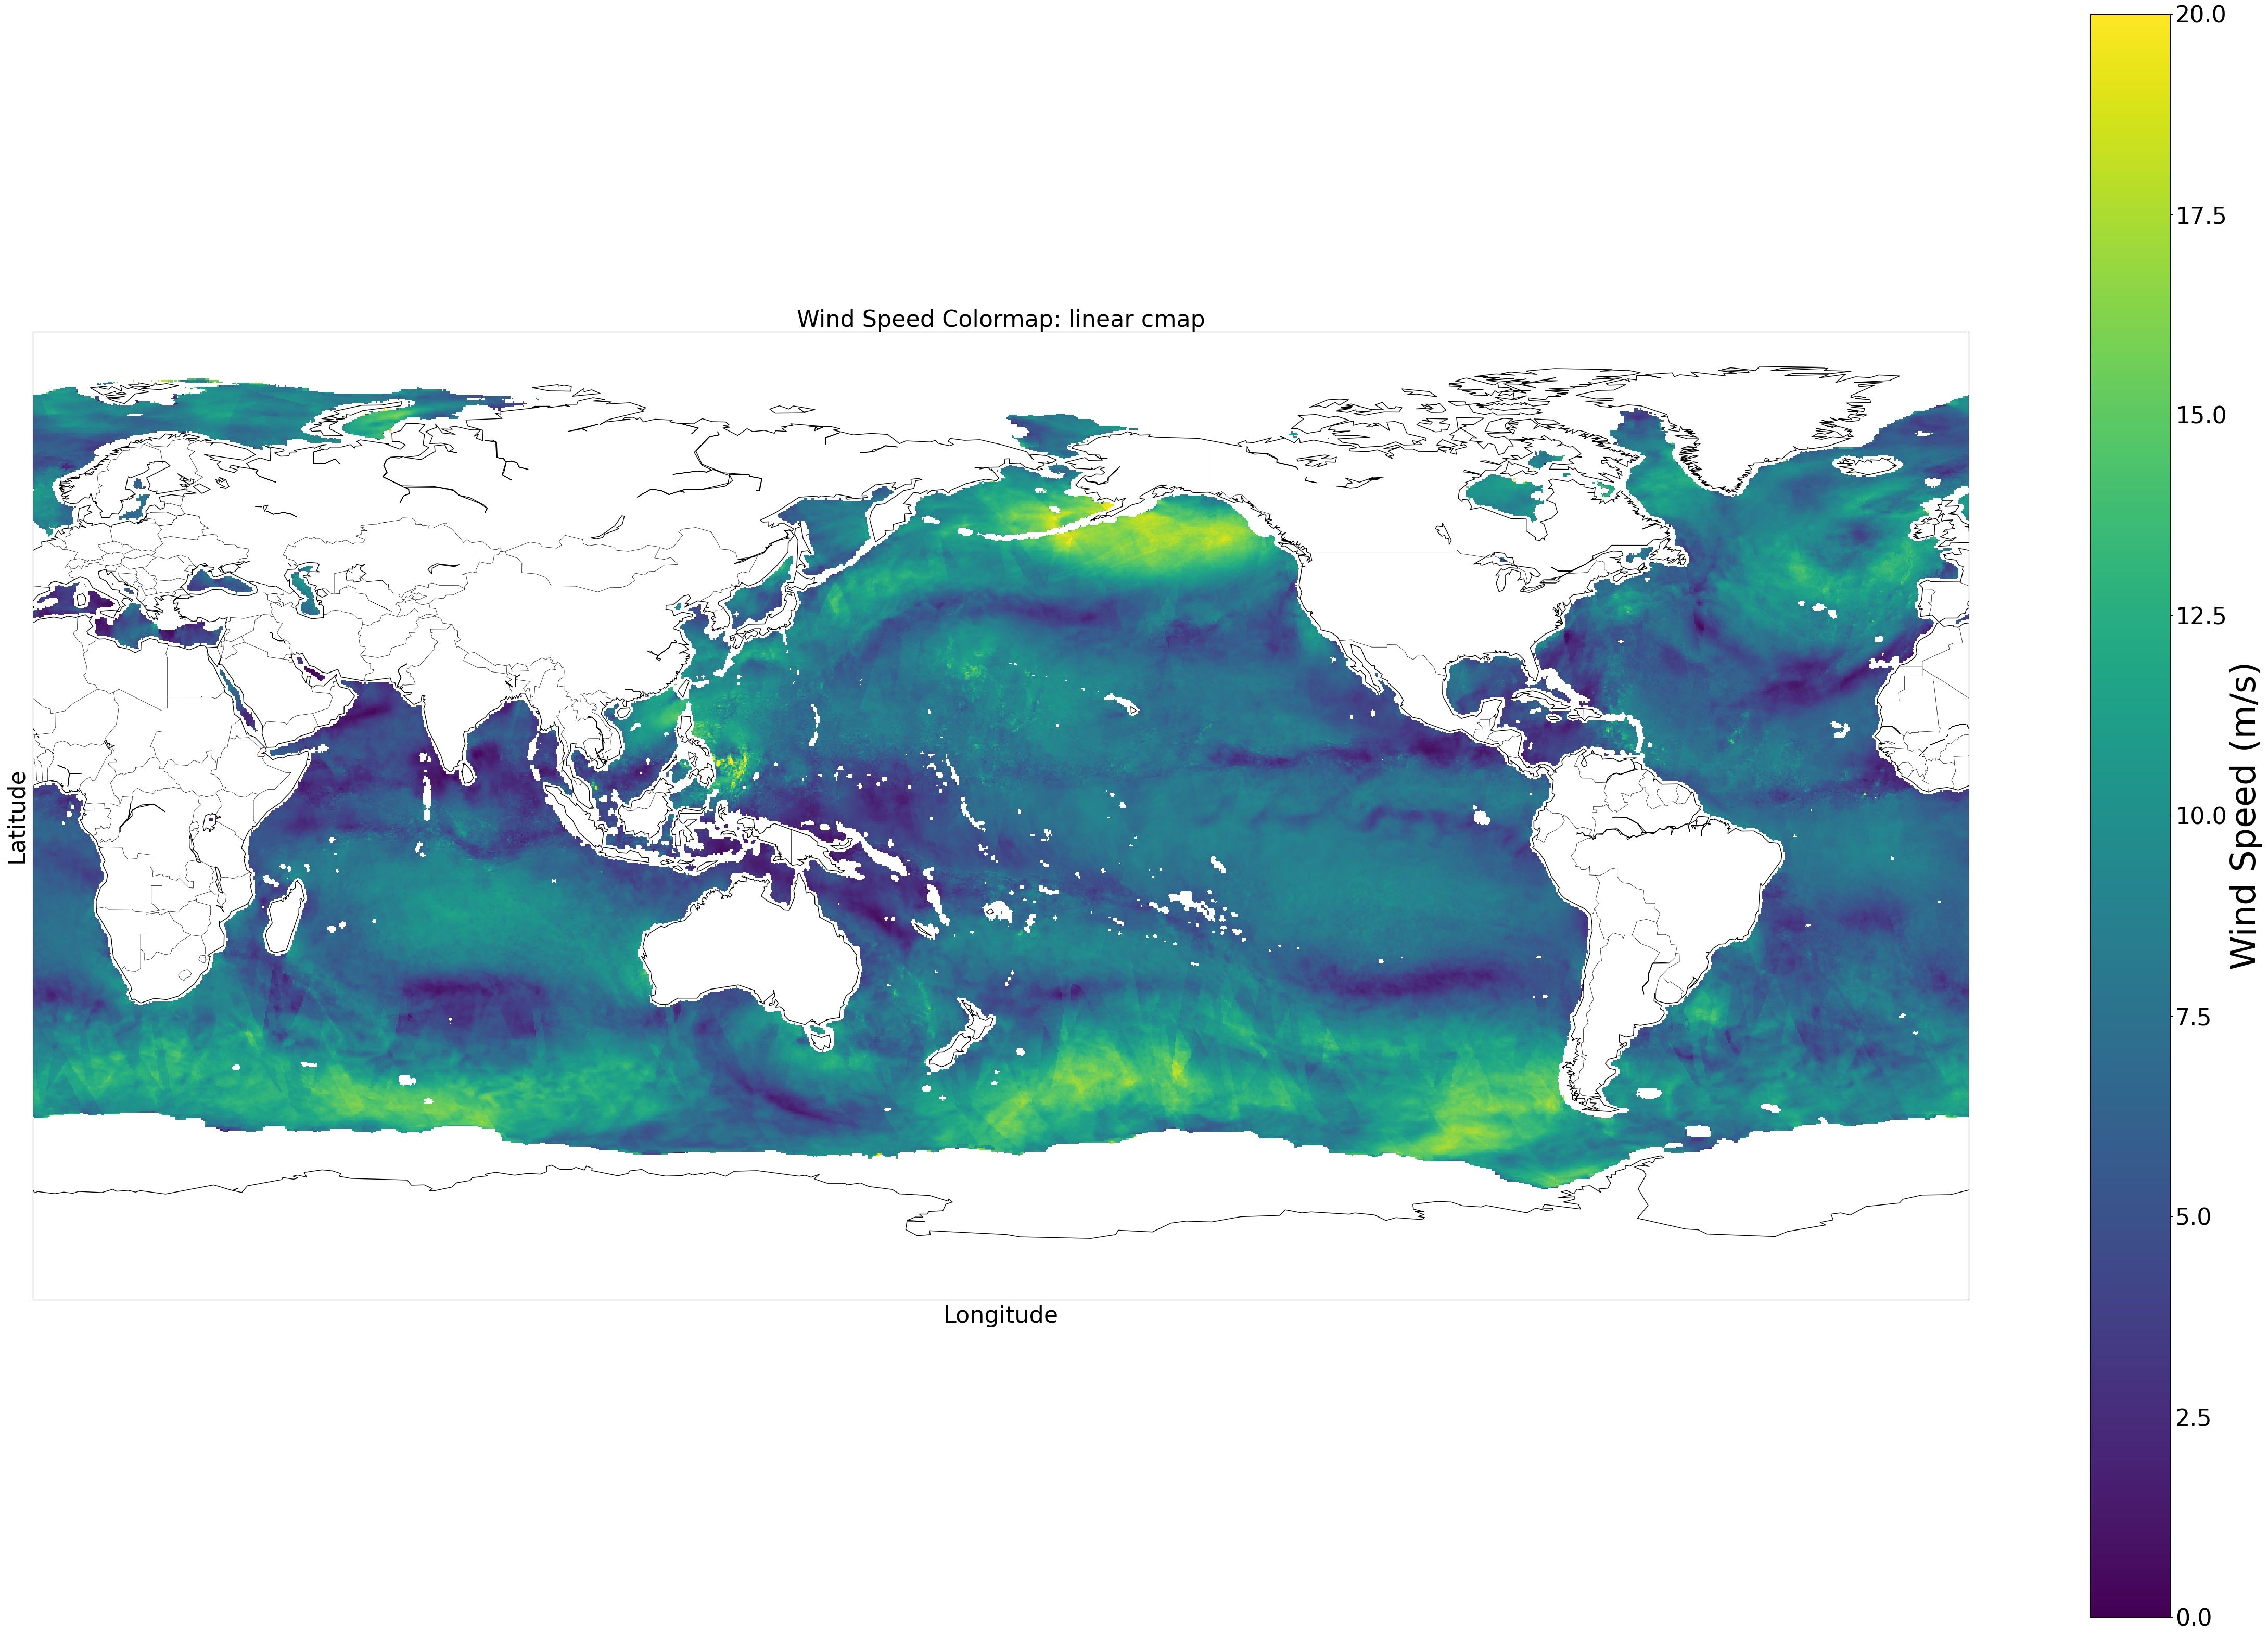

In [12]:
vmin = 0
vmax = 20
# Create a b instance for the world map
m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Create a figure and axis
fig = plt.figure(figsize=(12*5, 8*5))
ax = fig.add_subplot(1, 1, 1)

# Draw the coastlines and countries
m.drawcoastlines()
m.drawcountries()


# Convert longitude and latitude to map coordinates
x, y = np.meshgrid(longitude, latitude)
x, y = m(x, y)

# Create the color plot (heatmap)
cax = ax.pcolormesh(x, y, wind_speed_data, cmap='viridis', shading='auto', vmin=0, vmax=20)

# Add a colorbar
cbar = fig.colorbar(cax)
cbar.ax.tick_params(labelsize=32)
cbar.set_label('Wind Speed (m/s)', fontsize=48)

# Add labels and title
ax.set_xlabel('Longitude', fontsize=32)
ax.set_ylabel('Latitude', fontsize=32)
ax.set_title('Wind Speed Colormap: linear cmap', fontsize=32)

# Show the plot
plt.show()


# 3.2 Logrithmic Colormap

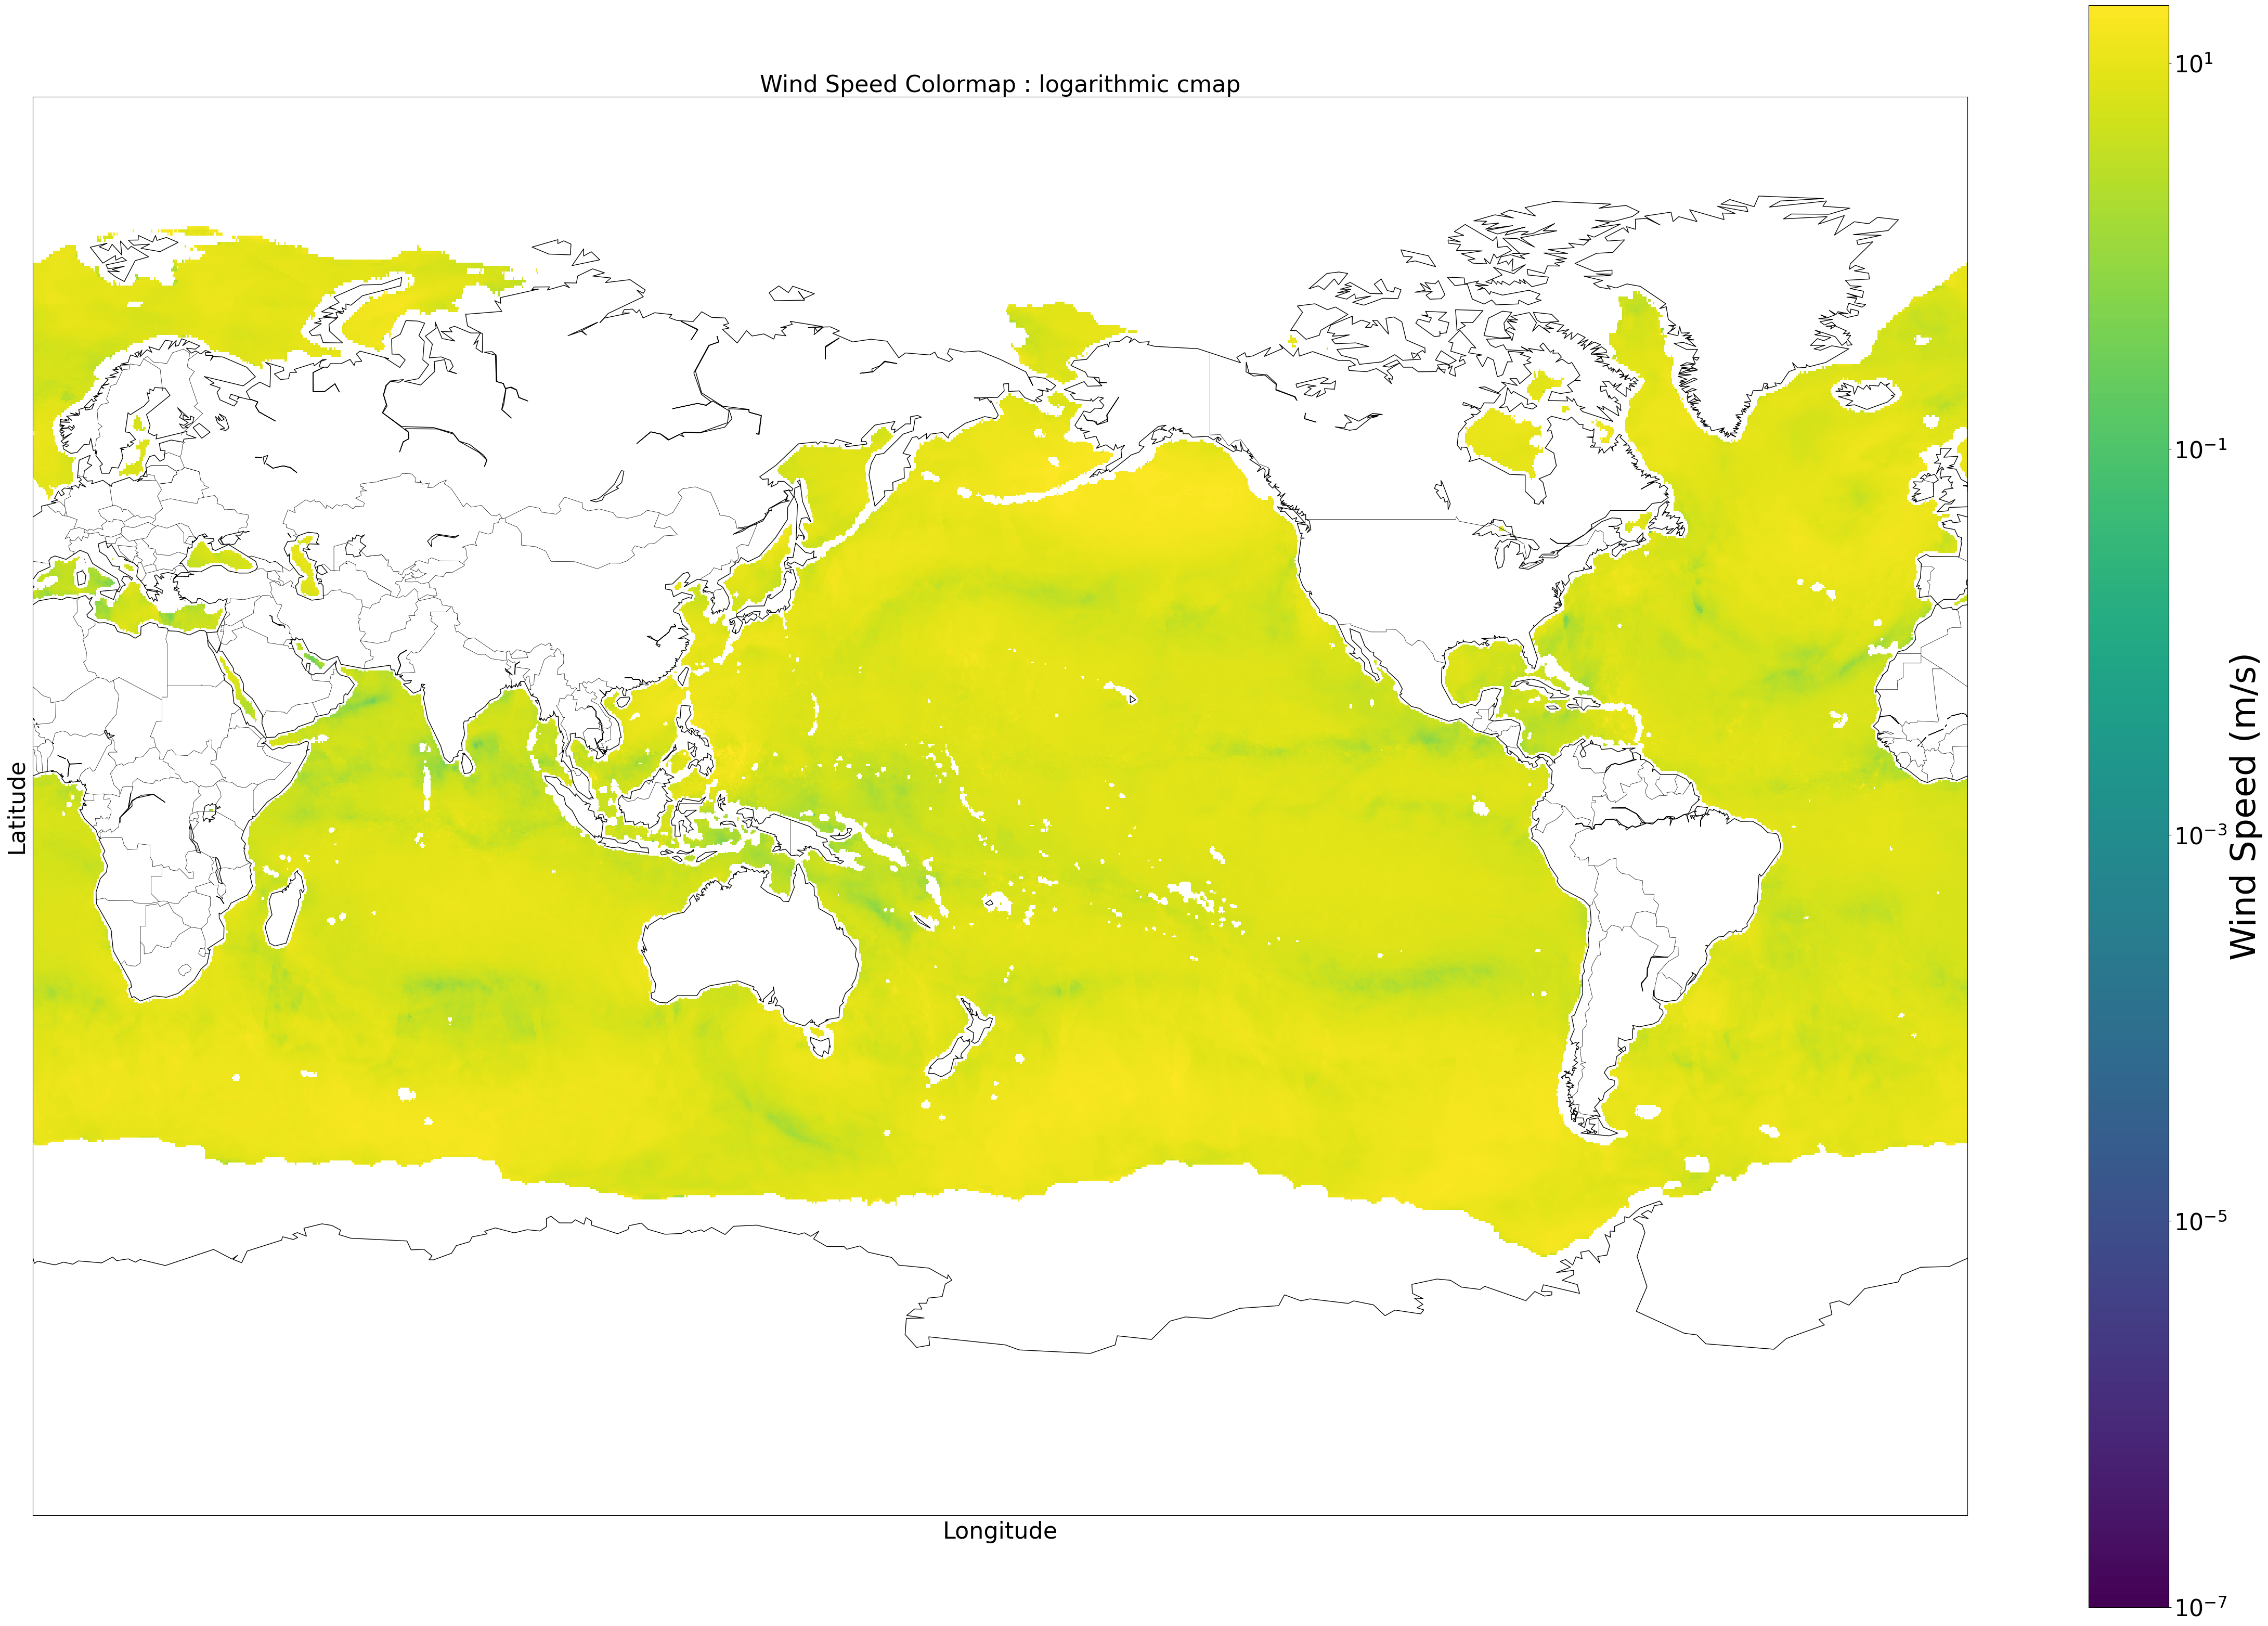

In [13]:
# Create a Basemap instance for the world map
m = Basemap(projection='mill', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Create a figure and axis
fig = plt.figure(figsize=(12*5, 8*5))
ax = fig.add_subplot(1, 1, 1)

# Draw the coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert longitude and latitude to map coordinates
x, y = np.meshgrid(longitude, latitude)
x, y = m(x, y)

# Create the color plot (heatmap) with logarithmic colormap
cax = ax.pcolormesh(x, y, wind_speed_data, cmap='viridis', norm=LogNorm(vmin=0.0000001, vmax=20), shading='auto')

# Add a colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Wind Speed (m/s)', fontsize=48)
cbar.ax.tick_params(labelsize=32)

# Add labels and title
ax.set_xlabel('Longitude', fontsize=32)
ax.set_ylabel('Latitude', fontsize=32)
ax.set_title('Wind Speed Colormap : logarithmic cmap', fontsize=32)

# Show the plot
plt.show()

# 3.3 Discrete Colormap

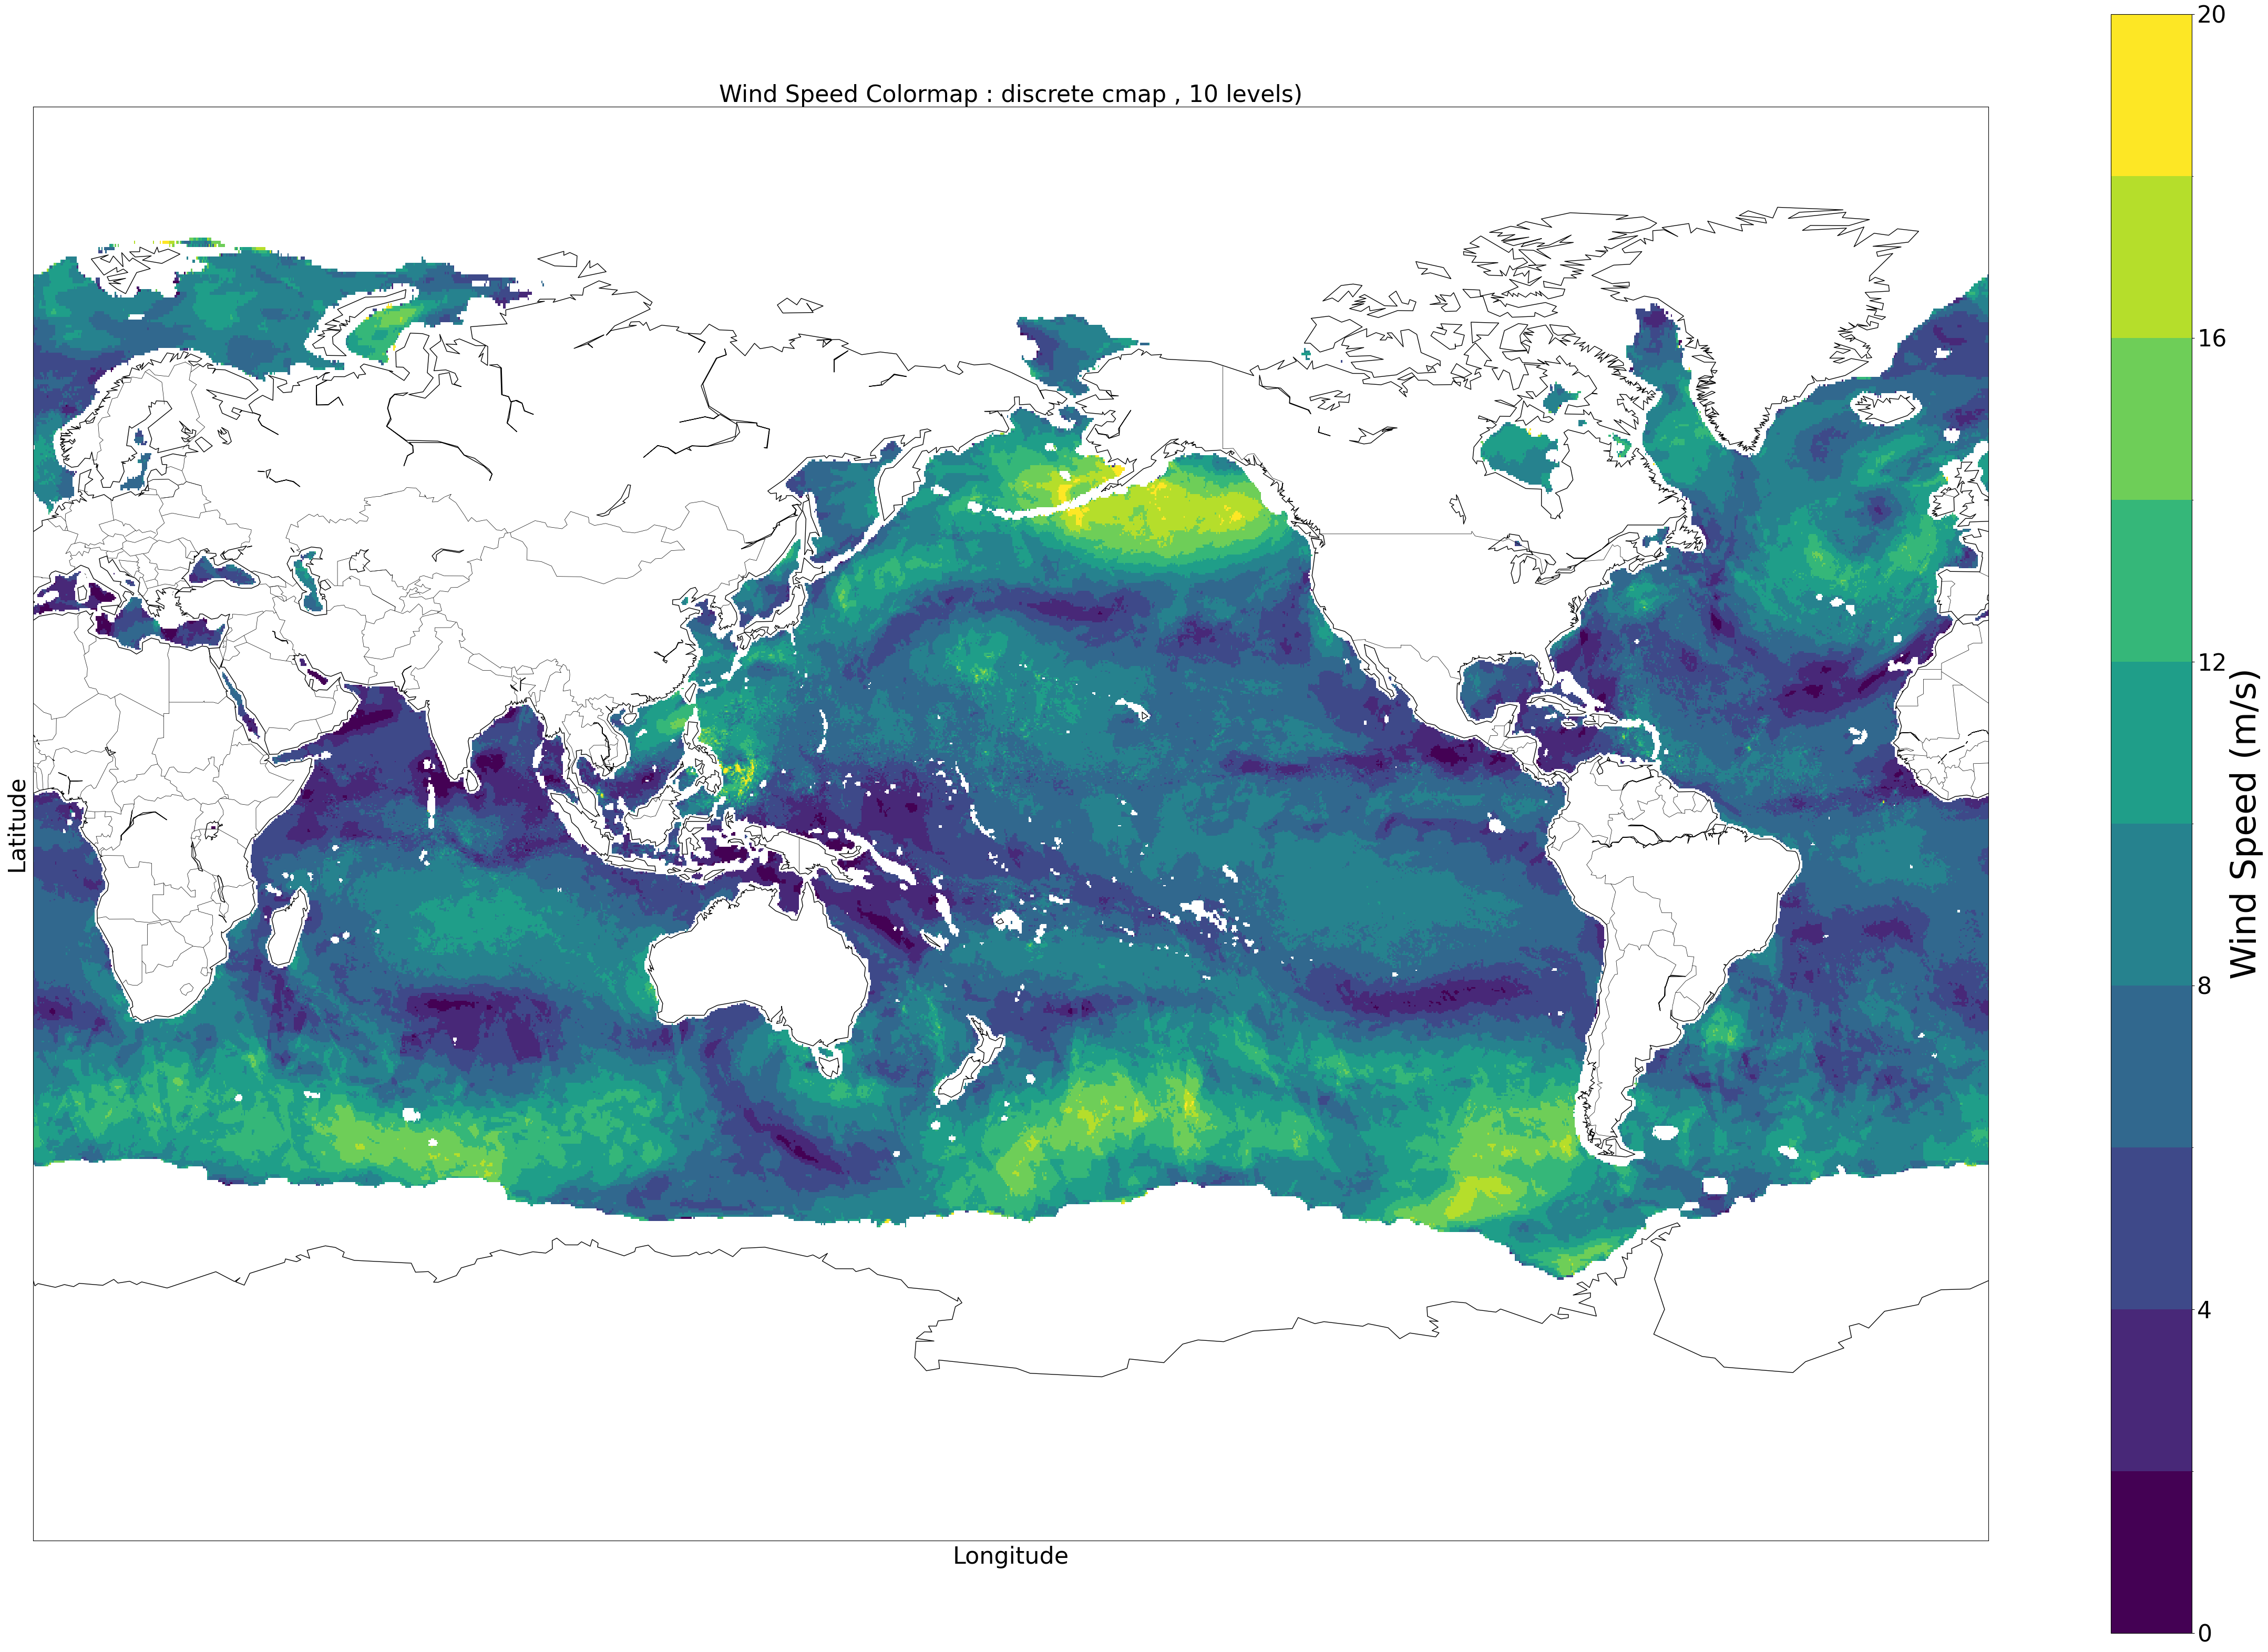

In [14]:
# Number of discrete levels in the colormap
num_levels = 10

# Define custom boundaries for discrete levels
boundaries = np.linspace(0, 20, num_levels + 1)

# Create a Basemap instance for the world map
m = Basemap(projection='mill', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Create a figure and axis
fig = plt.figure(figsize=(12*5, 8*5))
ax = fig.add_subplot(1, 1, 1)

# Draw the coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert longitude and latitude to map coordinates
x, y = np.meshgrid(longitude, latitude)
x, y = m(x, y)

# Create a ListedColormap with the desired number of colors
cmap = plt.get_cmap('viridis', num_levels)

# Create the color plot (heatmap) with discrete levels in the colormap
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
cax = ax.pcolormesh(x, y, wind_speed_data, cmap=cmap, shading='auto', norm=norm)

# Add a colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Wind Speed (m/s)', fontsize=48)
cbar.ax.tick_params(labelsize=32)


# Add labels and title
ax.set_xlabel('Longitude', fontsize=32)
ax.set_ylabel('Latitude', fontsize=32)
ax.set_title(f'Wind Speed Colormap : discrete cmap , {num_levels} levels)', fontsize=32)

# Show the plot
plt.show()

# 4. Automating the Process

In [15]:
def color_mapping(file_path, colormap, colormap_type, date):
    """
    Args:
        file_path -- path to .nc file
        colormap -- cmap like viridis
        colormap_type -- lin, log, dis
        date -- date of the dataset
    Returns:
         -- nothing --
    """
    dSet = nc.Dataset(file_path)
    
    longitude = dSet["lon"][:].data
    latitude = dSet["lat"][:].data
    wind_speed_data = dSet['wind_speed_AW'][:].data.squeeze()
    wind_speed_data[wind_speed_data < 0] = np.nan
    
    if colormap_type == "lin":
       # Create a b instance for the world map
        m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

        # Create a figure and axis
        fig = plt.figure(figsize=(12*5, 8*5))
        ax = fig.add_subplot(1, 1, 1)

        # Draw the coastlines and countries
        m.drawcoastlines()
        m.drawcountries()


        # Convert longitude and latitude to map coordinates
        x, y = np.meshgrid(longitude, latitude)
        x, y = m(x, y)

        # Create the color plot (heatmap)
        cax = ax.pcolormesh(x, y, wind_speed_data, cmap=colormap, shading='auto', vmin=0, vmax=20)

        # Add a colorbar
        cbar = fig.colorbar(cax)
        cbar.ax.tick_params(labelsize=32)
        cbar.set_label('Wind Speed (m/s)', fontsize=48)

        # Add labels and title
        ax.set_xlabel('Longitude', fontsize=32)
        ax.set_ylabel('Latitude', fontsize=32)
        ax.set_title(f'Wind Speed Colormap on {date} : linear cmap', fontsize=32)

        save_dir = f"./maps/{date}" 
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        temp = colormap+"_"+colormap_type+'.png'
        save_path = file_path = os.path.join(save_dir, temp)
        plt.savefig(save_path)
        plt.close(fig)
        
    elif colormap_type == 'log':
        # Create a Basemap instance for the world map
        m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

        # Create a figure and axis
        fig = plt.figure(figsize=(12*5, 8*5))
        ax = fig.add_subplot(1, 1, 1)

        # Draw the coastlines and countries
        m.drawcoastlines()
        m.drawcountries()

        # Convert longitude and latitude to map coordinates
        x, y = np.meshgrid(longitude, latitude)
        x, y = m(x, y)

        # Create the color plot (heatmap) with logarithmic colormap
        cax = ax.pcolormesh(x, y, wind_speed_data, cmap=colormap, norm=LogNorm(vmin=0.0000001, vmax=20), shading='auto')

        # Add a colorbar
        cbar = fig.colorbar(cax)
        cbar.set_label('Wind Speed (m/s)', fontsize=48)
        cbar.ax.tick_params(labelsize=32)

        # Add labels and title
        ax.set_xlabel('Longitude', fontsize=32)
        ax.set_ylabel('Latitude', fontsize=32)
        ax.set_title(f'Wind Speed Colormap on {date} : logarithmic cmap', fontsize=32)

        save_dir = f"./maps/{date}"  
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        temp = colormap+"_"+colormap_type+'.png'
        save_path = file_path = os.path.join(save_dir, temp)
        plt.savefig(save_path)
        plt.close(fig)
    
    elif colormap_type == "dis":
        
       # Number of discrete levels in the colormap
        num_levels = 10

        # Define custom boundaries for discrete levels
        boundaries = np.linspace(0, 20, num_levels + 1)

        # Create a Basemap instance for the world map
        m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

        # Create a figure and axis
        fig = plt.figure(figsize=(12*5, 8*5))
        ax = fig.add_subplot(1, 1, 1)

        # Draw the coastlines and countries
        m.drawcoastlines()
        m.drawcountries()

        # Convert longitude and latitude to map coordinates
        x, y = np.meshgrid(longitude, latitude)
        x, y = m(x, y)

        # Create a ListedColormap with the desired number of colors
        cmap = plt.get_cmap(colormap, num_levels)

        # Create the color plot (heatmap) with discrete levels in the colormap
        norm = BoundaryNorm(boundaries, cmap.N, clip=True)
        cax = ax.pcolormesh(x, y, wind_speed_data, cmap=cmap, shading='auto', norm=norm)

        # Add a colorbar
        cbar = fig.colorbar(cax)
        cbar.set_label('Wind Speed (m/s)', fontsize=48)
        cbar.ax.tick_params(labelsize=32)


        # Add labels and title
        ax.set_xlabel('Longitude', fontsize=32)
        ax.set_ylabel('Latitude', fontsize=32)
        ax.set_title(f'Wind Speed Colormap on {date} : discrete cmap , {num_levels} levels)', fontsize=32)

        # Show the plot
        save_dir = f"./maps/{date}" 
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        temp = colormap+"_"+colormap_type+'.png'
        save_path = file_path = os.path.join(save_dir, temp)
        plt.savefig(save_path)
        plt.close(fig)
    else:
        print("colormap_type should be in [\"lin\", \"log\", \"dis\"]")
        
    print(file_path, colormap, colormap_type)

In [16]:
# getting all the file names
dates = [1, 8, 15, 22, 29]
months = ["aug", "sept", "oct"]
complete_dates = []
file_paths = []
for month in months:
    for date in dates:
        temp = "./dataset/"+str(date)+month+"2022.nc"
        file_paths.append(temp)
        temp = str(date)+month+"2022"
        complete_dates.append(temp)
        
file_paths, complete_dates

(['./dataset/1aug2022.nc',
  './dataset/8aug2022.nc',
  './dataset/15aug2022.nc',
  './dataset/22aug2022.nc',
  './dataset/29aug2022.nc',
  './dataset/1sept2022.nc',
  './dataset/8sept2022.nc',
  './dataset/15sept2022.nc',
  './dataset/22sept2022.nc',
  './dataset/29sept2022.nc',
  './dataset/1oct2022.nc',
  './dataset/8oct2022.nc',
  './dataset/15oct2022.nc',
  './dataset/22oct2022.nc',
  './dataset/29oct2022.nc'],
 ['1aug2022',
  '8aug2022',
  '15aug2022',
  '22aug2022',
  '29aug2022',
  '1sept2022',
  '8sept2022',
  '15sept2022',
  '22sept2022',
  '29sept2022',
  '1oct2022',
  '8oct2022',
  '15oct2022',
  '22oct2022',
  '29oct2022'])

In [17]:
# getting our colormaps
colormaps = ["viridis", "magma", "jet", "coolwarm", "Greys", "twilight"]

In [18]:
# colormap types
colormap_types = ["lin", "log", "dis"]

In [19]:
# generating all colormaps
for file_path, complete_date in zip(file_paths, complete_dates):
    for colormap in colormaps:
        for colormap_type in colormap_types:
            color_mapping(file_path, colormap, colormap_type, complete_date)

./maps/1aug2022\viridis_lin.png viridis lin
./maps/1aug2022\viridis_log.png viridis log
./maps/1aug2022\viridis_dis.png viridis dis
./maps/1aug2022\magma_lin.png magma lin
./maps/1aug2022\magma_log.png magma log
./maps/1aug2022\magma_dis.png magma dis
./maps/1aug2022\jet_lin.png jet lin
./maps/1aug2022\jet_log.png jet log
./maps/1aug2022\jet_dis.png jet dis
./maps/1aug2022\coolwarm_lin.png coolwarm lin
./maps/1aug2022\coolwarm_log.png coolwarm log
./maps/1aug2022\coolwarm_dis.png coolwarm dis
./maps/1aug2022\Greys_lin.png Greys lin
./maps/1aug2022\Greys_log.png Greys log
./maps/1aug2022\Greys_dis.png Greys dis
./maps/1aug2022\twilight_lin.png twilight lin
./maps/1aug2022\twilight_log.png twilight log
./maps/1aug2022\twilight_dis.png twilight dis
./maps/8aug2022\viridis_lin.png viridis lin
./maps/8aug2022\viridis_log.png viridis log
./maps/8aug2022\viridis_dis.png viridis dis
./maps/8aug2022\magma_lin.png magma lin
./maps/8aug2022\magma_log.png magma log
./maps/8aug2022\magma_dis.png ma

./maps/1oct2022\coolwarm_dis.png coolwarm dis
./maps/1oct2022\Greys_lin.png Greys lin
./maps/1oct2022\Greys_log.png Greys log
./maps/1oct2022\Greys_dis.png Greys dis
./maps/1oct2022\twilight_lin.png twilight lin
./maps/1oct2022\twilight_log.png twilight log
./maps/1oct2022\twilight_dis.png twilight dis
./maps/8oct2022\viridis_lin.png viridis lin
./maps/8oct2022\viridis_log.png viridis log
./maps/8oct2022\viridis_dis.png viridis dis
./maps/8oct2022\magma_lin.png magma lin
./maps/8oct2022\magma_log.png magma log
./maps/8oct2022\magma_dis.png magma dis
./maps/8oct2022\jet_lin.png jet lin
./maps/8oct2022\jet_log.png jet log
./maps/8oct2022\jet_dis.png jet dis
./maps/8oct2022\coolwarm_lin.png coolwarm lin
./maps/8oct2022\coolwarm_log.png coolwarm log
./maps/8oct2022\coolwarm_dis.png coolwarm dis
./maps/8oct2022\Greys_lin.png Greys lin
./maps/8oct2022\Greys_log.png Greys log
./maps/8oct2022\Greys_dis.png Greys dis
./maps/8oct2022\twilight_lin.png twilight lin
./maps/8oct2022\twilight_log.png

# 5. GIF

In [20]:
def gif_generator(colormap, colormap_type):
    dates = [1, 8, 15, 22, 29]
    months = ["aug", "sept", "oct"]
    image_paths = []
    for month in months:
        for date in dates:
            temp = "./maps/"+str(date)+month+f"2022/{colormap}_"+colormap_type+".png"
            image_paths.append(temp)
    images = [Image.open(filename) for filename in image_paths]
    
    save_dir = f"./gif_{colormap_type}" 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    images[0].save(f"./gif_{colormap_type}/aug_oct_{colormap}_{colormap_type}.gif", save_all=True, append_images=images[1:], duration=256, loop=0)

In [21]:
for colormap in colormaps:
    for colormap_type in colormap_types:
        
        gif_generator(colormap, colormap_type)